In [1]:
library(AER)
library(tseries)
library(car)
library(sandwich)
library(lmtest)
library(gmm)
library(systemfit)
library(dynlm)

Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: survival
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: Matrix

Please cite the 'systemfit' package as:
Arne Henningsen and Jeff D. Hamann (2007). systemfit: A Package for Estimating Systems of Simultaneous Equations in R. Journal of Statistical Software 23(4), 1-40. http://www.jstatsoft.org/v23/i04/.

If you have questions, suggestions, or comments regarding the 'systemfit' package, please use a forum or 'tracker' at systemfit's R-Forge site:
https://r-forge.r-project.org/projects/systemfit/


- `revr_pop`: revenu réel par tête CAD Dollars
- `pr_fr`: prix réel du fromage 
- `pr_lait`: prix réel du lait
- `pr_beurre`: prix réel du beurre
- `prod_kgpc`: Production - Consommation 1000 tonnes
- `vaches_pc`: nombre de vaches par personne

In [2]:
FROM <- read.table("Fromage_Simplifie.csv",
                   head = TRUE,
                   sep = ";"
                  )
head(FROM)

annee,lnrevr_pop,lnpr_fr,lnpr_lait,lnpr_beurre,lnprod_kgpc,lnvaches_pc
1990,10.24105,7.911923,5.635742,8.853665,2.221297,-3.037330
1991,10.21554,7.879228,5.673965,8.866311,2.234913,-3.084700
1992,10.21535,8.064344,5.671904,8.864250,2.230217,-3.144463
1993,10.19927,8.017932,5.653421,8.845767,2.233415,-3.154624
1994,10.19220,8.857543,5.652058,8.844405,2.274501,-3.148238
1995,10.17309,8.835892,5.630407,8.822753,2.288799,-3.164791


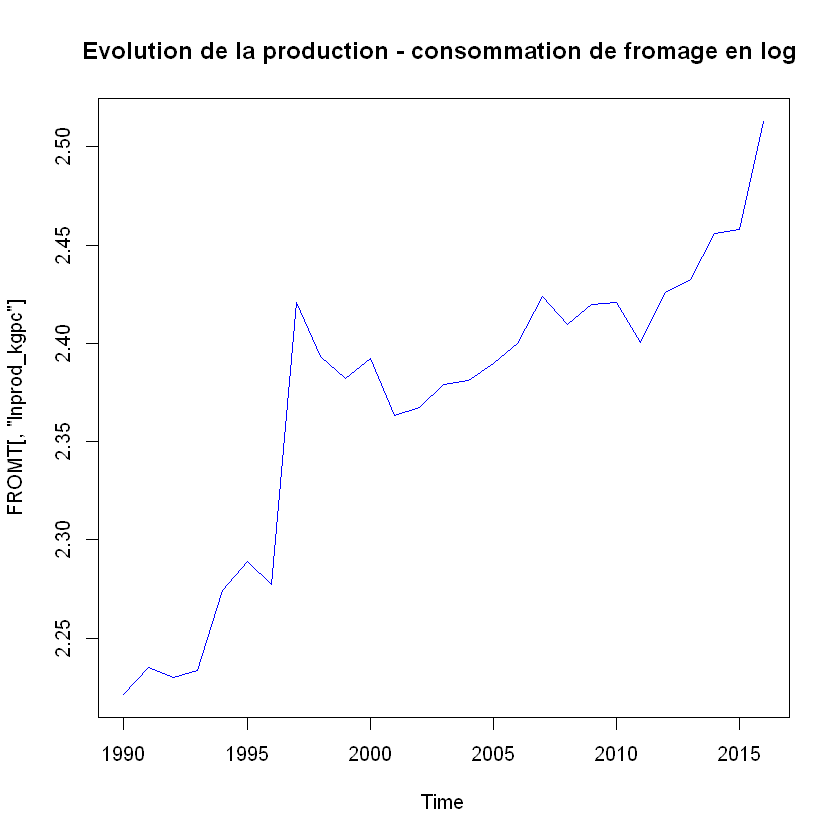

In [4]:
FROMT <- ts(data = FROM,
            start = 1990,
            end = 2016,
            frequency = 1,
            deltat = 1
           )

ts.plot(FROMT[, "lnprod_kgpc"],
        main = "Evolution de la production - consommation de fromage en log ",
        col = "blue"
       )

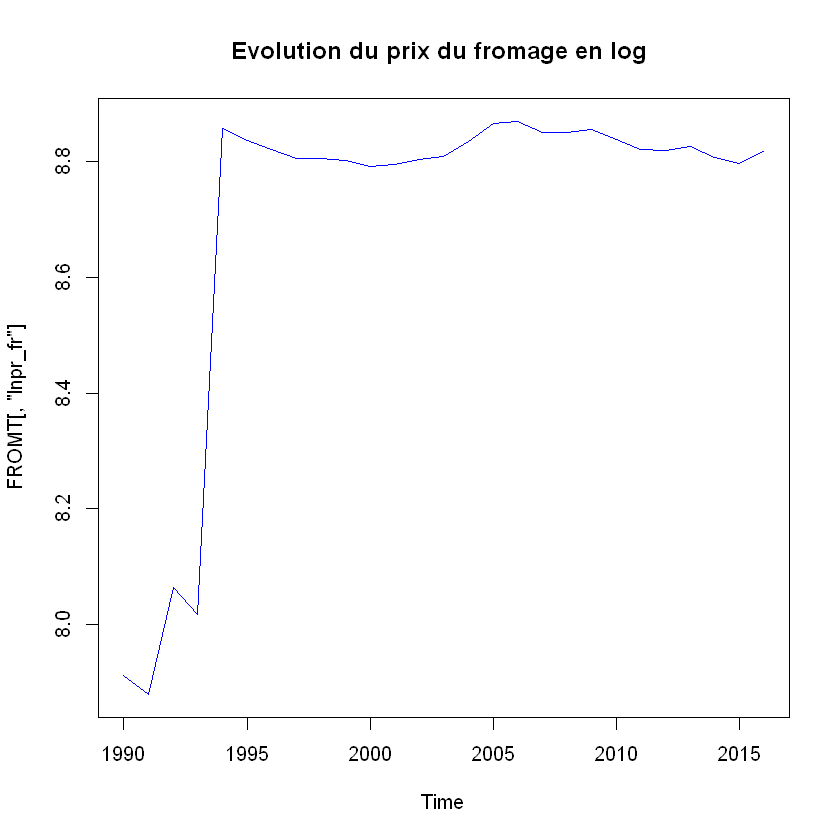

In [6]:
ts.plot(FROMT[, "lnpr_fr"],
        main = "Evolution du prix du fromage en log ",
        col = "blue"
       )

In [7]:
summary(FROMT)
cor(FROMT)

     annee        lnrevr_pop       lnpr_fr        lnpr_lait      lnpr_beurre   
 Min.   :1990   Min.   :10.13   Min.   :7.879   Min.   :5.599   Min.   :8.779  
 1st Qu.:1996   1st Qu.:10.16   1st Qu.:8.798   1st Qu.:5.673   1st Qu.:8.793  
 Median :2003   Median :10.16   Median :8.818   Median :6.468   Median :8.812  
 Mean   :2003   Mean   :10.17   Mean   :8.698   Mean   :6.243   Mean   :8.818  
 3rd Qu.:2010   3rd Qu.:10.17   3rd Qu.:8.837   3rd Qu.:6.516   3rd Qu.:8.843  
 Max.   :2016   Max.   :10.24   Max.   :8.869   Max.   :6.544   Max.   :8.866  
  lnprod_kgpc     lnvaches_pc    
 Min.   :2.221   Min.   :-3.624  
 1st Qu.:2.326   1st Qu.:-3.556  
 Median :2.392   Median :-3.401  
 Mean   :2.370   Mean   :-3.383  
 3rd Qu.:2.421   3rd Qu.:-3.205  
 Max.   :2.513   Max.   :-3.037  

,annee,lnrevr_pop,lnpr_fr,lnpr_lait,lnpr_beurre,lnprod_kgpc,lnvaches_pc
annee,1.0000000,-0.5704188,0.6176860,0.7994827,-0.3445591,0.8944389,-0.9890016
lnrevr_pop,-0.5704188,1.0000000,-0.8255636,-0.5749338,0.5666069,-0.6910118,0.5892076
lnpr_fr,0.6176860,-0.8255636,1.0000000,0.6163874,-0.5413975,0.7431669,-0.6353781
lnpr_lait,0.7994827,-0.5749338,0.6163874,1.0000000,-0.3932041,0.8057081,-0.8548139
lnpr_beurre,-0.3445591,0.5666069,-0.5413975,-0.3932041,1.0000000,-0.5362434,0.3209230
lnprod_kgpc,0.8944389,-0.6910118,0.7431669,0.8057081,-0.5362434,1.0000000,-0.8942133
lnvaches_pc,-0.9890016,0.5892076,-0.6353781,-0.8548139,0.3209230,-0.8942133,1.0000000


**Equations de comportement FSM**

In [8]:
EQD <- lnprod_kgpc ~ lnpr_fr + lnpr_beurre + lnrevr_pop
EQO <- lnprod_kgpc ~ lnpr_fr + lnpr_lait + lnvaches_pc  

**Equation equilibre  : production = consommation**

In [9]:
instruments <- ~ lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc 

**Estimation de la forme reduite du modèle avec la fonction `lm`**

In [10]:
EQ1_FRM <- lm(lnprod_kgpc ~ lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc,
              data = FROMT
             )
summary(EQ1_FRM)


Call:
lm(formula = lnprod_kgpc ~ lnpr_beurre + lnrevr_pop + lnpr_lait + 
    lnvaches_pc, data = FROMT)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041903 -0.018659  0.000856  0.012872  0.075627 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.718611   3.163518   3.388  0.00264 ** 
lnpr_beurre -0.637738   0.262877  -2.426  0.02392 *  
lnrevr_pop  -0.372589   0.335109  -1.112  0.27821    
lnpr_lait    0.004488   0.029487   0.152  0.88040    
lnvaches_pc -0.306211   0.062890  -4.869 7.24e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03013 on 22 degrees of freedom
Multiple R-squared:  0.8761,	Adjusted R-squared:  0.8536 
F-statistic:  38.9 on 4 and 22 DF,  p-value: 1.122e-09


In [11]:
EQ2_FRM <- lm(lnpr_fr ~ lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc,
              data = FROMT
             )
summary(EQ2_FRM)


Call:
lm(formula = lnpr_fr ~ lnpr_beurre + lnrevr_pop + lnpr_lait + 
    lnvaches_pc, data = FROMT)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31542 -0.08874 -0.01343  0.09686  0.46981 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 96.59767   18.68068   5.171 3.49e-05 ***
lnpr_beurre -1.19106    1.55230  -0.767 0.451066    
lnrevr_pop  -7.74073    1.97883  -3.912 0.000748 ***
lnpr_lait    0.04722    0.17412   0.271 0.788762    
lnvaches_pc -0.30252    0.37137  -0.815 0.424026    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1779 on 22 degrees of freedom
Multiple R-squared:  0.7251,	Adjusted R-squared:  0.6751 
F-statistic: 14.51 on 4 and 22 DF,  p-value: 6.082e-06


**Estimation de la forme reduite du modèle avec la fonction `systemfit`**

In [12]:
EQ1_FRM1 <- lnprod_kgpc ~ lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc
EQ2_FRM1 <- lnpr_fr ~ lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc

SystemFRM <- list(EQ1_FRM1, EQ2_FRM1)
FRM_MCO <- systemfit(SystemFRM, "OLS", data = FROMT, maxit = 100)
summary(FRM_MCO, residCov = FALSE, equations = FALSE)


systemfit results 
method: OLS 

        N DF      SSR detRCov   OLS-R2 McElroy-R2
system 54 44 0.716584 2.7e-05 0.734134    0.80738

     N DF      SSR      MSE     RMSE       R2   Adj R2
eq1 27 22 0.019978 0.000908 0.030134 0.876119 0.853595
eq2 27 22 0.696606 0.031664 0.177944 0.725099 0.675116


Coefficients:
                   Estimate  Std. Error  t value   Pr(>|t|)    
eq1_(Intercept) 10.71861061  3.16351816  3.38819 0.00264477 ** 
eq1_lnpr_beurre -0.63773790  0.26287711 -2.42599 0.02391824 *  
eq1_lnrevr_pop  -0.37258943  0.33510948 -1.11184 0.27820832    
eq1_lnpr_lait    0.00448845  0.02948655  0.15222 0.88040048    
eq1_lnvaches_pc -0.30621053  0.06289026 -4.86897 7.2392e-05 ***
eq2_(Intercept) 96.59767240 18.68067714  5.17099 3.4856e-05 ***
eq2_lnpr_beurre -1.19106295  1.55229782 -0.76729 0.45106569    
eq2_lnrevr_pop  -7.74072666  1.97883234 -3.91176 0.00074774 ***
eq2_lnpr_lait    0.04722203  0.17411905  0.27121 0.78876154    
eq2_lnvaches_pc -0.30252123  0.37136900 -0.8

**Estimation des équations de la FSM avec les DMC avec la fonction `ivreg`**

In [13]:
EQ1_DMC = ivreg(lnprod_kgpc ~ lnpr_fr + lnpr_beurre + lnrevr_pop |
                lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc,
                data = FROMT
               )
summary(EQ1_DMC, diagnostics = TRUE)


Call:
ivreg(formula = lnprod_kgpc ~ lnpr_fr + lnpr_beurre + lnrevr_pop | 
    lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc, data = FROMT)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.369229 -0.071540  0.006511  0.077171  0.232441 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -67.2468    53.7086  -1.252   0.2231  
lnpr_fr       0.8031     0.4531   1.772   0.0896 .
lnpr_beurre   0.3746     1.2902   0.290   0.7741  
lnrevr_pop    5.8343     4.4883   1.300   0.2065  

Diagnostic tests:
                 df1 df2 statistic  p-value    
Weak instruments   2  22     1.423    0.262    
Wu-Hausman         1  22    50.948 3.71e-07 ***
Sargan             1  NA     0.076    0.783    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.136 on 23 degrees of freedom
Multiple R-Squared: -1.638,	Adjusted R-squared: -1.982 
Wald test: 2.524 on 3 and 23 DF,  p-value: 0.08272 


In [14]:
EQ2_DMC = ivreg(lnprod_kgpc ~ lnpr_fr + lnpr_lait + lnvaches_pc |
                lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc,
                data = FROMT
               )
summary(EQ2_DMC, diagnostics = TRUE)


Call:
ivreg(formula = lnprod_kgpc ~ lnpr_fr + lnpr_lait + lnvaches_pc | 
    lnpr_beurre + lnrevr_pop + lnpr_lait + lnvaches_pc, data = FROMT)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.04832 -0.01499 -0.01049  0.01633  0.08475 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.588737   0.225106   2.615  0.01547 * 
lnpr_fr      0.100383   0.037715   2.662  0.01394 * 
lnpr_lait    0.008927   0.032257   0.277  0.78446   
lnvaches_pc -0.251948   0.070750  -3.561  0.00166 **

Diagnostic tests:
                 df1 df2 statistic  p-value    
Weak instruments   2  22    12.063 0.000291 ***
Wu-Hausman         1  22     1.292 0.267852    
Sargan             1  NA     3.907 0.048081 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03296 on 23 degrees of freedom
Multiple R-Squared: 0.845,	Adjusted R-squared: 0.8248 
Wald test: 42.23 on 3 and 23 DF,  p-value: 1.616e-09 


**Estimation de la FSM avec system `fit`**

In [15]:
SystemFSM <- list(EQD, EQO)
model_DMC <- systemfit(SystemFSM, "2SLS", inst = instruments, data = FROMT, maxit = 100)
summary(model_DMC, residCov = FALSE, equations = FALSE)


systemfit results 
method: 2SLS 

        N DF      SSR detRCov    OLS-R2 McElroy-R2
system 54 46 0.450443 1.5e-05 -0.396601   0.714511

     N DF      SSR      MSE     RMSE        R2   Adj R2
eq1 27 23 0.425451 0.018498 0.136007 -1.638226 -1.98234
eq2 27 23 0.024992 0.001087 0.032964  0.845025  0.82481


Coefficients:
                    Estimate   Std. Error  t value  Pr(>|t|)   
eq1_(Intercept) -67.24678010  53.70855101 -1.25207 0.2231283   
eq1_lnpr_fr       0.80306331   0.45308704  1.77243 0.0895714 . 
eq1_lnpr_beurre   0.37463277   1.29018145  0.29037 0.7741336   
eq1_lnrevr_pop    5.83426130   4.48834845  1.29987 0.2065233   
eq2_(Intercept)   0.58873689   0.22510567  2.61538 0.0154675 * 
eq2_lnpr_fr       0.10038325   0.03771492  2.66163 0.0139384 * 
eq2_lnpr_lait     0.00892668   0.03225723  0.27673 0.7844560   
eq2_lnvaches_pc  -0.25194771   0.07074987 -3.56111 0.0016609 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

___
**Obtenir les valeurs estimées**

In [ ]:
fiteqd <- fitted(model_DMC$eq[[1]])
fiteqo <- fitted(model_DMC$eq[[2]])

tsfiteqd <- ts(fiteqd, start = 1990, end = 2016, frequency = 1, deltat = 1)
tsfiteqo <- ts(fiteqo, start = 1990, end = 2016, frequency = 1, deltat = 1)

ts.plot(FROMT[, "lnprod_kgpc"],
        tsfiteqd, tsfiteqo,
        col = 1:3
       )

legend("topleft",
       c("lnq_obs", "lnq_d", "lnq_o"), bty = "n", col = 1:3, lty = rep(1,3)
      )